### Chapter 8 :Pascal object detection

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload  2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(1)# if you have multiple GPUS this command can help you to choose between them

### Pascal VOC
We will be looking at the Pascal VOC dataset. It's quite slow, so you may prefer to download from this mirror. There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library pathlib for our paths and file access. Note that it returns an OS-specific class (on Linux, PosixPath) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like cv2) can't, in which case you can use str() to convert it to a string.

cd ~/fastai/courses/dl2

ln -s ~/data data && cd $_

mkdir pascal && cd $_

curl -OL http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

curl -OL https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip

tar -xf VOCtrainval_06-Nov-2007.tar

unzip PASCAL_VOC.zip

mv PASCAL_VOC/*.json .

rmdir PASCAL_VOC



In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/.ipynb_checkpoints'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2007.json')]

As well as the images, there are also annotations - bounding boxes showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from this link.

You can see here how pathlib includes the ability to open files (amongst many other capabilities).

In [4]:
trn_j =json.load((PATH /'pascal_train2007.json').open()) #load annotations 
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

## Image information
    filename - the related image with filename
    height - how big the height of the image is
    width - how big the width of the image is
    id - the image id for joining to other datasets

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images','annotations','categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
torch.cuda.set_device(0)# 0 is for only one GPU 


### Bounding Boxes
  bbox: column, row (top left) , height, width
  
  id: which image
  
  category_id : which label
  
  segmentation : ignore of this tutorail (polygon bounding)

In [7]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

### Make a lookup from id to name

In [8]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [9]:
trn_j[CATEGORIES][:]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 




It’s helpful to use constants instead of strings, since we get tab-completion and don’t mistype.

In [10]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'


cats = dict((o[ID],o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID],o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids =[o[ID] for o in trn_j[IMAGES]]

In [15]:

cats #categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

### Lets take a look at whats in the VOC 2007 dataset

In [16]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

In [17]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages' #Store the Image path

### Make a compound path

In [18]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005928.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007260.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006806.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/009168.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005984.jpg')]

In [19]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A defaultdict is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC’s height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.
We are swapping dimensions, to be consistent, numpy, ROWS x COLUMNS

{
    IMG_ID  : (array(top_left_row, top_left_col, lower_right_row, lower_right_col), CAT_ID)
}

In [20]:
#initialize the default dictionary
trn_anno = collections.defaultdict(lambda:[])

#for each annotaions 
for o in trn_j[ANNOTATIONS]:
    # if not ignore
    if not o['ignore']:
        #get the orignal bounding box information
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        
        #
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

len(trn_anno)

2501

## Example1

In [21]:
im_a = trn_anno[im0_d[ID]]; im_a # ?? what is being done here

[(array([ 96, 155, 269, 350]), 7)]

In [22]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [23]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [24]:
cats[15],cats[12]

('person', 'dog')

##  Create a short function that will change a boundbox to height & width to translate data

In [25]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

We will use fast.ai’s open_image library to create an image to view

In [26]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

### Create a short function to show the image in the notebook
Matplotlib’s plt.subplots is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [27]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

### Create an outlining function
A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here’s how to do it in matplotlib.

In [28]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw,foreground='black'),patheffects.Normal()])

Note that * in argument lists is the splat operator2. In this case it’s a little shortcut compared to writing out b[-2],b[-1].

### Make a rectangle for the bounding box

In [29]:
def draw_rect(ax,b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill = False,edgecolor = 'white', lw = 2 ))
    draw_outline(patch, 4)

### Make a quick function to write the text label (for the category)


In [30]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

### Test out Showing an Image

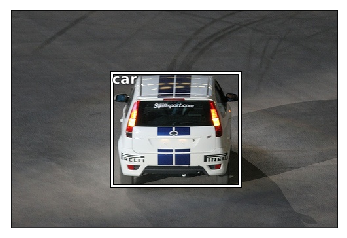

In [33]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax,b[:2],cats[im0_a[1]])

### Let’s make a function to show multiple objects on a single image

In [34]:
def draw_im(im, ann):
    ax = show_img(im, figsize = (16,8))
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax,b)
        draw_text(ax, b[:2], cats[c], sz = 16)
        

In [35]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


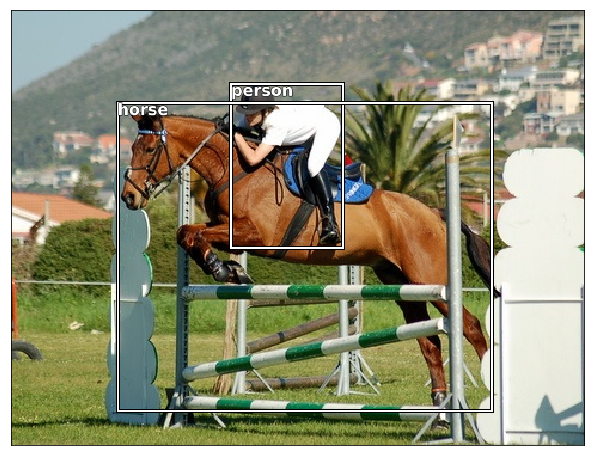

In [36]:
draw_idx(17)

### Next Complex step - Largest Item Classifier
A lambda function is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

This snippet sorts the objets

   sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)

We subtract the upper left from the bottom right and multiply (np.product) the values to get an area.
lambda x: np.product(x[0][-2:]-x[0][:2])



In [37]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key = lambda x: np.product(x[0][-2:]-x[0][:2]), reverse = True)
    return b[0]

####  dictionary comprehension - storing the biggest objects:

In [38]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

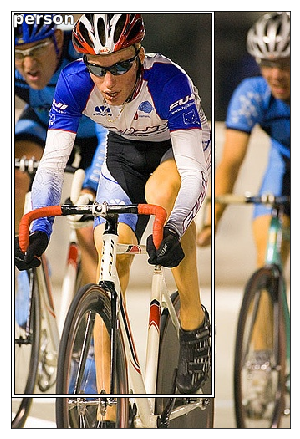

In [39]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

### Let’s store the largest object per file in a CSV file

In [40]:
(PATH/'tmp').mkdir(exist_ok = True)
CSV = PATH/'tmp/lrg.csv'

Often it’s easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [41]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

#### Make a Resnet model to learn
##### Considerations
    The training images are different sized
    Since we are doing bounding boxes, many of the objects are near the edge, so     we want to be careful not to cut the objects off the picture
    So we will put CropType.NO so we will “squish” instead

In [42]:
f_model = resnet34
sz=224
bs=64

In [43]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

##### A note on Data Loaders
    A data loader is an iterator that will provide a mini-batch of data ( subset). But first we need to ensure that we start at the beginning of the dataset. Pythons’ iter() method will create an iterator object and start at the beginning of the dataset. And afterwards our iterator will have __next__ that can be used to pull a mini-batch

In [44]:
md.trn_dl

In [45]:
x,y=next(iter(md.val_dl))

#### Some observations
    not a numpy array
    not on the CPU
    [torch.cuda.FloatTensor of size 2x3x224x224 (GPU 0)] shape is wrong
    not numbers between 0 and 1

In [46]:
x[:2]


( 0 , 0 ,.,.) = 
  3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
  5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
  5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                 ...                   ⋱                   ...                
  1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
  9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
  5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01

( 0 , 1 ,.,.) = 
  2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
  3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
  5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                 ...                   ⋱                   ...                
  1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01
  8.4169e-01  9.

In [47]:
imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
inception_stats = A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (inception_4, inceptionresnet_2)    

def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT):
    if aug_tfms is None: aug_tfms=[]
    #-----------------------------------------------NOTETHEMANIPULATIOn
    tfm_norm = Normalize(*stats, tfm_y=tfm_y)
    tfm_denorm = Denormalize(*stats)
    #-----------------------------------------------NOTETHEMANIPULATION
    val_crop = CropType.CENTER if crop_type==CropType.RANDOM else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop, tfm_y=tfm_y, sz_y=sz_y)
    trn_tfm=image_gen(tfm_norm, tfm_denorm, sz, tfms=aug_tfms, max_zoom=max_zoom,
                      pad=pad, crop_type=crop_type, tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode)
    return trn_tfm, val_tfm

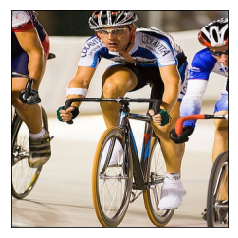

In [48]:
show_img(md.val_ds.denorm(to_np(x))[0]);

####  Using Resnet 34
Get a pretrained learner

In [49]:
learn = ConvLearner.pretrained(f_model, md, metrics = [accuracy])
learn.opt_fn = optim.Adam

#### Find learning rate

In [50]:
lrf = learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s, loss=14.4]

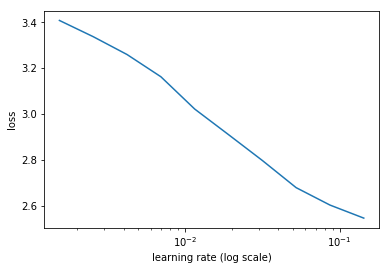

In [51]:
learn.sched.plot()

##### to change the truncation of the plot use the below command

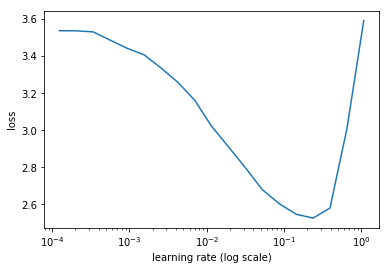

In [52]:
learn.sched.plot(n_skip=5, n_skip_end=1)

#### Set learning rate

In [53]:
lr = 2e-2

In [54]:
learn.fit(lr,1,cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 47%|████▋     | 15/32 [00:07<00:08,  2.11it/s, loss=1.63]


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.257588   0.590062   0.823017  



[0.5900618, 0.8230168297886848]

In [55]:
learn.fit(lr, 1, cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.993896   0.899639   0.773888  
    1      0.784707   0.67873    0.803936                  
    2      0.615271   0.591822   0.826923                  
    3      0.480065   0.616519   0.826923                  



[0.61651856, 0.8269230797886848]

In [56]:
lrs = np.array([lr/1000, lr/100,lr])

#### We freeze all layers except the last two layers, find new learning rate and retrain

In [57]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:17<00:03,  1.53it/s, loss=1.98] 

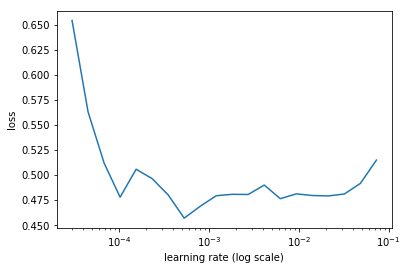

In [58]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [59]:
learn.fit(lrs/4,1,cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

  3%|▎         | 1/32 [00:02<01:15,  2.45s/it, loss=0.43]

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.494169   0.678326   0.810397  
    1      0.35006    0.669304   0.824519                  
    2      0.274385   0.631439   0.833233                  
    3      0.215389   0.631214   0.826923                  



[0.6312139, 0.8269230797886848]

In [60]:
learn.fit(lrs/4,1,cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.227912   0.778039   0.813251  
    1      0.187726   0.756016   0.807392                  
    2      0.132321   0.750176   0.821064                  
    3      0.10337    0.750157   0.826923                  



[0.75015736, 0.8269230797886848]

#### Accuracy is still at 83%

In [61]:
learn.unfreeze()

In [62]:
learn.fit(lrs/4, 1, cycle_len=6)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.102312   0.851213   0.813251  
    1      0.106599   0.847043   0.804988                   
    2      0.079594   0.887571   0.813251                   
    3      0.063433   0.921989   0.81866                    
    4      0.050228   0.903476   0.810847                   
    5      0.044636   0.908768   0.816707                   



[0.908768, 0.8167067319154739]

In [63]:
learn.save('clas_one')
learn.load('clas_one')

In [64]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

##### Python Debugger .pdb

*
 * pdb.set_trace() to set a breakpoint
 
 * %debug magic to trace an error

Commands you need to know:

* s / n / c
* u / d
* p # print
* l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


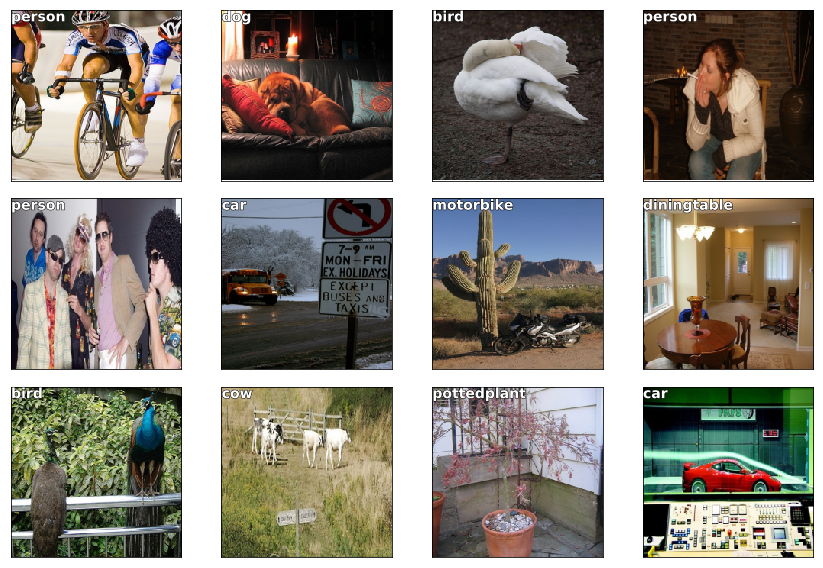

In [65]:
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima,ax=ax)
    draw_text(ax,(0,0), b)
plt.tight_layout()

There are some worong classifications as bike is not the largest thing in picture.But still good accuracy

##### Bbox only


Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [66]:
#BB_CSV = PATH/'tmp/bb.csv'

In [67]:
#bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
#bb

array([[ 96, 155, 269, 350],
       [ 77,  89, 335, 402],
       [  1,   2, 461, 242],
       ...,
       [ 89,  24, 311, 426],
       [141, 191, 186, 329],
       [  3,  68, 344, 391]])

In [68]:
#bbs = [''.join(str(p) for p in o) for o in bb]
#bbs

['96155269350',
 '7789335402',
 '12461242',
 '12489211336',
 '77103182374',
 '1068262498',
 '166115399359',
 '97217317464',
 '7826343318',
 '31262294499',
 '00329369',
 '014311458',
 '01499301',
 '10273278436',
 '220499450',
 '181241258273',
 '142120459374',
 '01332305',
 '7414411474',
 '32108308446',
 '5021290316',
 '240124283194',
 '61332282',
 '17369327276',
 '1935473429',
 '073461271',
 '1772499405',
 '1140329486',
 '53223331439',
 '1121400499',
 '5224398417',
 '1043214564',
 '146236190357',
 '7558265366',
 '150332497',
 '33103389445',
 '142195368308',
 '10725395455',
 '153113347368',
 '2093490374',
 '63108463287',
 '4142332425',
 '940335239',
 '3864345458',
 '63115374355',
 '379374499',
 '3585223238',
 '133159238285',
 '18226248399',
 '2040319112',
 '7513374399',
 '332119463309',
 '12639291463',
 '235113374226',
 '95124262354',
 '8191227313',
 '26539374276',
 '22286498',
 '12396296149',
 '957231490',
 '0170360498',
 '95342195499',
 '22318322354',
 '162128318229',
 '88110374416',
 

In [69]:
#df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids],'bbox':bbs}, columns = ['fn','bbox'])

In [70]:
#df

fn          bbox
0     000012.jpg   96155269350
1     000017.jpg    7789335402
2     000023.jpg      12461242
3     000026.jpg   12489211336
4     000032.jpg   77103182374
5     000033.jpg    1068262498
6     000034.jpg  166115399359
7     000035.jpg   97217317464
8     000036.jpg    7826343318
9     000042.jpg   31262294499
10    000044.jpg      00329369
11    000047.jpg     014311458
12    000048.jpg      01499301
13    000061.jpg   10273278436
14    000064.jpg     220499450
15    000066.jpg  181241258273
16    000073.jpg  142120459374
17    000077.jpg      01332305
18    000078.jpg    7414411474
19    000083.jpg   32108308446
20    000089.jpg    5021290316
21    000091.jpg  240124283194
22    000104.jpg      61332282
23    000112.jpg   17369327276
24    000122.jpg    1935473429
25    000129.jpg     073461271
26    000133.jpg    1772499405
27    000134.jpg    1140329486
28    000138.jpg   53223331439
29    000140.jpg    1121400499
...          ...           ...
2471  009851.jpg   13590266248
2472  009852.jpg  120152374481
2473  009855.jpg   31106279499
2474  009859.jpg   39109332343
2475  009860.jpg    2464354489
2476  009867.jpg     270374308
2477  009868.jpg   13872414233
2478  009869.jpg      52374352
2479  009872.jpg  307113373274
2480  009874.jpg  157115479237
2481  009877.jpg    1012499288
2482  009878.jpg   11873348373
2483  009879.jpg  163397226497
2484  009882.jpg   15413371282
2485  009884.jpg    7784374399
2486  009887.jpg  260221315264
2487  009896.jpg  133138322371
2488  009904.jpg   34271388159
2489  009911.jpg   13674264416
2490  009918.jpg      00329267
2491  009920.jpg    2128418320
2492  009926.jpg    5297358489
2493  009938.jpg   54136339319
2494  009940.jpg  132134374364
2495  009942.jpg      81331364
2496  009944.jpg   11986290328
2497  009945.jpg   19891228131
2498  009949.jpg    8924311426
2499  009959.jpg  141191186329
2500  009961.jpg     368344391

[2501 rows x 2 columns]

In [71]:
#df.to_csv(BB_CSV,index = False)

In [88]:
#BB_CSV.open().readlines()[:5]

### Set our model and parameters

In [89]:
BB_CSV = PATH/'tmp/bb_scaled.csv'

f_model=resnet34
sz=224
bs=64

def scale_bb(img_h, img_w, bb, targ):

    h_ratio = targ/img_h # height (y-axis) scale factor
    w_ratio = targ/img_w # width (x-axis) scale factor
    
    # scale each bb coordinate respectively in order of [y_upperleft, x_upperleft, y_lowerright, x_lowerright]
    bb_scaled = np.asarray([bb[0]*h_ratio, bb[1]*w_ratio, bb[2]*h_ratio, bb[3]*w_ratio]).astype(int)
    
    return bb_scaled

bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bb_scaled = [scale_bb(img['height'], img['width'], bb, sz) for img, bb in zip(trn_j['images'], bb)]
bbs = [' '.join(str(p) for p in o) for o in bb_scaled]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)


#### Tell fast.ai to make a continous network model


Set continuous=True to tell fastai this is a regression problem, which means it won’t one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to ‘squish’ the rectangular images into squares, rather than center cropping, so that we don’t accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it’s generally large and centrally located).

In [90]:
#tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)
#md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [91]:
x,y=next(iter(md.val_dl))

We'll use it to add the classes to the bounding boxes labels.

In [92]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0]));b

array([ 48.,   0., 133., 206.], dtype=float32)

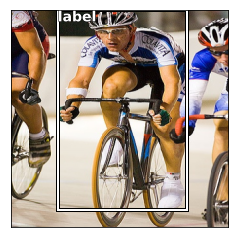

In [93]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

fastai let's you use a custom_head to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [94]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [95]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:09<00:02,  2.63it/s, loss=413]


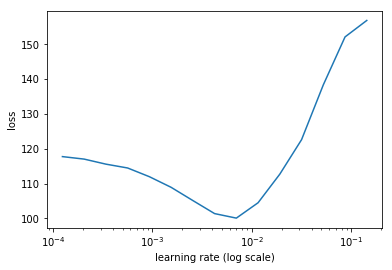

In [96]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [97]:
lr = 2e-3

In [98]:
learn.fit(lr, 2, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      48.203215  35.132607 
    1      36.825589  28.41066                            
    2      30.871845  27.682205                           



[27.682205]

In [99]:
lrs = np.array([lr/100,lr/10,lr])

In [100]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      64.337382  2164635063025664.0



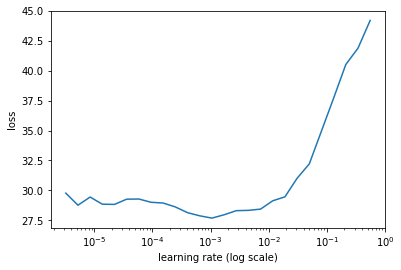

In [101]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [102]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      26.766909  23.147184 
    1      22.110836  22.442381                           
    2      18.880909  21.569201                           
    3      15.423132  19.311256                           
    4      12.271791  19.243475                           



[19.243475]

In [103]:
learn.freeze_to(-3)

In [105]:
learn.fit(lrs, 1, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      12.110089  21.258076 
    1      13.582508  20.82542                            
    2      12.598393  19.298258                           
    3      10.364639  18.873749                           
    4      8.491051   18.748123                           



[18.748123]

In [106]:
learn.save('reg4')
learn.load('reg4')

In [107]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


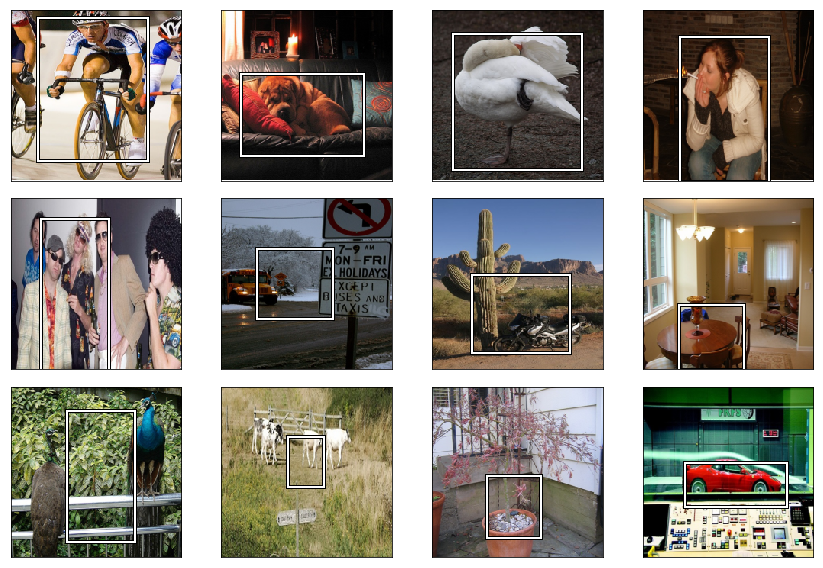

In [108]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

#### Single object detection

In [110]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [111]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [112]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with __len__ and __getitem__. Here's a dataset that adds a 2nd label to an existing dataset:

In [113]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [114]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [115]:
val_ds2[0][1]

(array([  0.,  33.,  92., 120.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [116]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to denormalize the images from the dataloader before they can be plotted.

In [118]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([ 0., 35., 99., 88.], dtype=float32)

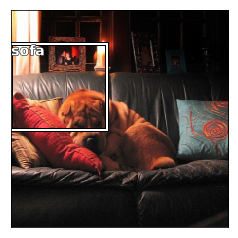

In [119]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [120]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [121]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:11<00:00,  2.61it/s, loss=814] 

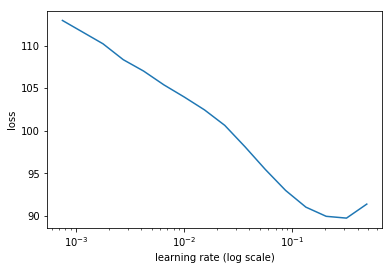

In [122]:
learn.lr_find()
learn.sched.plot()

In [123]:
lr=1e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s, loss=87]

Exception in thread Thread-49:
Traceback (most recent call last):
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      64.005925  35.219215  0.781701   21.907377 
    1      43.285848  29.414335  0.81866    16.924189     
    2      33.711962  27.367916  0.826923   16.115758     



[27.367916, 0.8269230797886848, 16.115757822990417]

In [124]:
learn.save('reg1_0')
learn.load('reg1_0')

In [125]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:19<00:02,  1.46it/s, loss=113] 

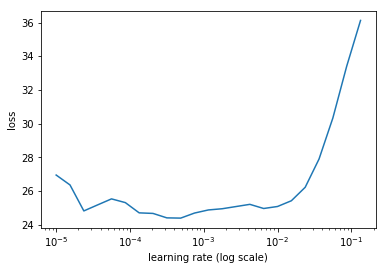

In [126]:
lrs = np.array([lr/100, lr/10, lr])
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [127]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                   


Exception in thread Thread-53:
Traceback (most recent call last):
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sgg_goel/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      26.70133   28.784721  0.810847   15.346963 
    1      21.895377  26.233097  0.817157   14.363173     
    2      18.094513  25.161673  0.835787   13.967837     
    3      15.614078  24.534073  0.834285   13.731814     
    4      13.992422  24.607508  0.835787   13.573046     



[24.607508, 0.835787259042263, 13.57304561138153]

In [128]:
learn.save('reg1')
learn.load('reg1')

In [129]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [130]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


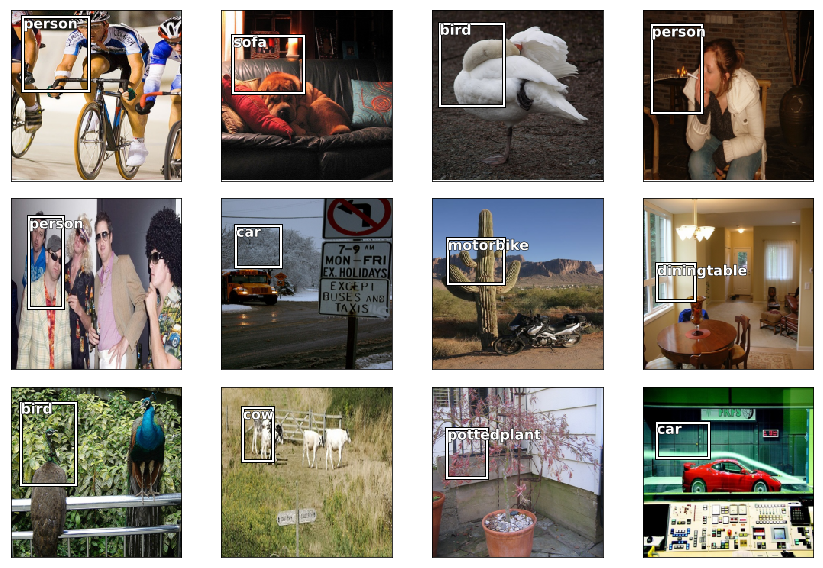

In [131]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

#### The End